# Делаем свой Portfolio Visualizer

Возможности:

* Получение цен для нескольких активов.
* Ребалансировка по месяцам и годам.
* Графики доходности/просадки.


In [1]:
import talib
import pandas as pd
import numpy as np
import warp_prism
import sqlalchemy as sa
import matplotlib.pyplot as plt
from datetime import date, timedelta
from functools import partial

/home/alex/env/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
metadata = sa.MetaData()
engine = sa.create_engine('postgresql://developer:1@localhost:5432/go_finance')
tbl_prices = sa.Table(
    'prices', metadata,
    sa.Column('symbol', sa.String(16)),
    sa.Column('dt', sa.Date),
    sa.Column('open', sa.FLOAT),
    sa.Column('high', sa.FLOAT),
    sa.Column('low', sa.FLOAT),
    sa.Column('close', sa.FLOAT),
    sa.Column('volume', sa.BIGINT),
    sa.Column('adj', sa.FLOAT),
)

In [3]:
SYMBOLS = ['SPY', 'DIA', 'QQQ', 'IWM', 'AGG', 'TLT', 'BND']
query = sa.select(tbl_prices.c).where(
    tbl_prices.c.symbol.in_(SYMBOLS)
).where(tbl_prices.c.dt <= date(2018, 12, 1).strftime('%Y-%m-%d')).order_by('symbol', 'dt')

In [4]:
def adjusting(df, is_adjusted):
    # adjusting prices with splits & dividends
    if not is_adjusted:
        ratio = df.adj / df.close
        df['open'] *= ratio
        df['high'] *= ratio
        df['low'] *= ratio
        df['close'] *= ratio
        df['volume'] = (df['volume'] / ratio).astype(int)
    return True
        
is_adjusted = False
df = warp_prism.to_dataframe(query, bind=engine)
print(df['symbol'].unique())

['AGG' 'BND' 'DIA' 'IWM' 'QQQ' 'SPY' 'TLT']


In [5]:
is_adjusted = adjusting(df, is_adjusted)  # adjusting for splits & dividends
print('Adjusted: ', df['symbol'].unique())

Adjusted:  ['AGG' 'BND' 'DIA' 'IWM' 'QQQ' 'SPY' 'TLT']


# Ставим индексы для группировки по тикерам и периодам

In [6]:
df = df.set_index(['dt', 'symbol'], drop=False).sort_index()
df.tail(len(df.index.levels[1]) * 2)

symbol         dt    open     high       low   close  \
dt         symbol                                                        
2018-08-09 AGG       AGG 2018-08-09  105.97  106.040  105.9329  106.00   
           BND       BND 2018-08-09   78.94   79.020   78.9200   79.02   
           DIA       DIA 2018-08-09  255.76  256.230  255.0000  255.16   
           IWM       IWM 2018-08-09  167.65  168.710  167.5500  168.00   
           QQQ       QQQ 2018-08-09  181.94  182.630  181.6400  181.91   
           SPY       SPY 2018-08-09  285.53  285.970  284.9150  285.07   
           TLT       TLT 2018-08-09  119.23  119.830  119.1200  119.79   
2018-08-10 AGG       AGG 2018-08-10  106.11  106.360  106.1100  106.23   
           BND       BND 2018-08-10   79.02   79.250   79.0200   79.18   
           DIA       DIA 2018-08-10  253.68  253.900  252.4000  253.30   
           IWM       IWM 2018-08-10  167.05  168.665  166.9600  167.53   
           QQQ       QQQ 2018-08-10  180.68  181.220  179.8400  180.52   
           SPY       SPY 2018-08-10  283.45  284.055  282.3600  283.16   
           TLT       TLT 2018-08-10  120.37  121.050  120.2800  120.66   

                     volume     adj  
dt         symbol                    
2018-08-09 AGG      2386423  106.00  
           BND      2603851   79.02  
           DIA      1677288  255.16  
           IWM     10437762  168.00  
           QQQ     18852898  181.91  
           SPY     35716976  285.07  
           TLT      7144257  119.79  
2018-08-10 AGG      4136263  106.23  
           BND      2414870   79.18  
           DIA      4797172  253.30  
           IWM     20521940  167.53  
           QQQ     33818464  180.52  
           SPY     77076044  283.16  
           TLT      8457940  120.66

# Группируем и рисуем графики цен

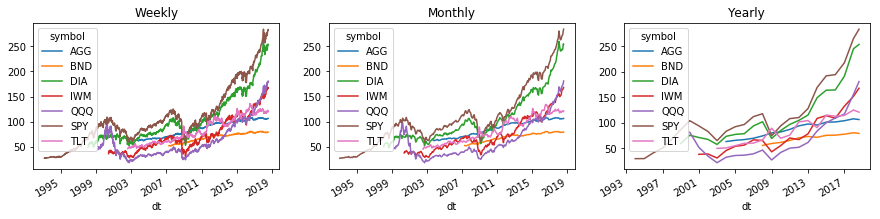

In [7]:
# правила обработки колонок при группировке
agg_rules = {
    'dt': 'last', 'symbol': 'last',
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last',
    'volume': 'sum', 'adj': 'last'
}
fig = plt.figure(figsize=(15, 3), facecolor='white')
level_values = df.index.get_level_values
df.groupby([pd.Grouper(freq='W', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(131), title="Weekly")
df.groupby([pd.Grouper(freq='M', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(132), title="Monthly")
df.groupby([pd.Grouper(freq='Y', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(133), title="Yearly")
plt.show()

# Обновляем индекс исходными датами

In [8]:
monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules)
monthly.tail(len(df.index.levels[1]))

dt symbol     open    high      low   close  \
dt         symbol                                                       
2018-08-31 AGG    2018-08-10    AGG  105.550  106.36  105.512  106.23   
           BND    2018-08-10    BND   78.750   79.25   78.650   79.18   
           DIA    2018-08-10    DIA  253.900  256.76  251.030  253.30   
           IWM    2018-08-10    IWM  165.700  168.71  164.495  167.53   
           QQQ    2018-08-10    QQQ  176.870  182.63  175.790  180.52   
           SPY    2018-08-10    SPY  281.560  286.01  279.160  283.16   
           TLT    2018-08-10    TLT  118.285  121.05  118.070  120.66   

                      volume     adj  
dt         symbol                     
2018-08-31 AGG      25861846  106.23  
           BND      19788791   79.18  
           DIA      22812877  253.30  
           IWM     135056634  167.53  
           QQQ     243271137  180.52  
           SPY     408720179  283.16  
           TLT      54717202  120.66

In [9]:
monthly = monthly.set_index(['dt', 'symbol'], drop=False)
monthly.tail(len(df.index.levels[1]))

dt symbol     open    high      low   close  \
dt         symbol                                                       
2018-08-10 AGG    2018-08-10    AGG  105.550  106.36  105.512  106.23   
           BND    2018-08-10    BND   78.750   79.25   78.650   79.18   
           DIA    2018-08-10    DIA  253.900  256.76  251.030  253.30   
           IWM    2018-08-10    IWM  165.700  168.71  164.495  167.53   
           QQQ    2018-08-10    QQQ  176.870  182.63  175.790  180.52   
           SPY    2018-08-10    SPY  281.560  286.01  279.160  283.16   
           TLT    2018-08-10    TLT  118.285  121.05  118.070  120.66   

                      volume     adj  
dt         symbol                     
2018-08-10 AGG      25861846  106.23  
           BND      19788791   79.18  
           DIA      22812877  253.30  
           IWM     135056634  167.53  
           QQQ     243271137  180.52  
           SPY     408720179  283.16  
           TLT      54717202  120.66

In [10]:
# monthly.loc[(slice(None), ['QQQ']), :]  # check every symbol

# Изменения за месяц в процентах и старт с 1

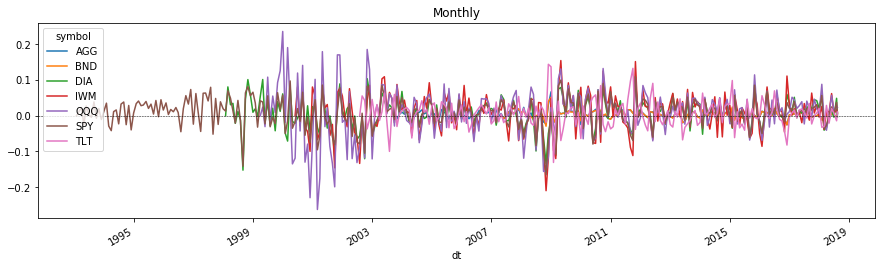

In [11]:
monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules) \
          .set_index(['dt', 'symbol'], drop=False)
# Get monthly changes in percent around 1 and set first items to 1
monthly['pct_close'] = monthly.groupby(level=1)['close'].pct_change().fillna(0) + 1

# Monthly changes
ax = (monthly.pct_close - 1).unstack(1).plot(title="Monthly", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()

# Сравнение доходности отдельных активов

In [12]:
rolling_prod = lambda x: x.rolling(len(x), min_periods=1).apply(np.prod)  # cumulative return
monthly['performance'] = monthly.groupby(level=1)['pct_close'].transform(rolling_prod) - 1
# monthly.loc[(slice(None), ['AGG']), :]  # one symbol's history

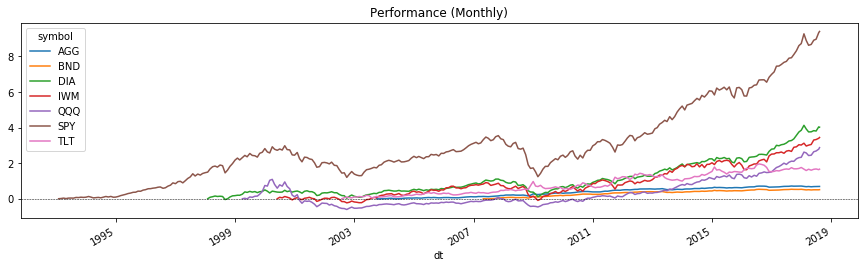

In [13]:
ax = monthly.performance.unstack(1).plot(title="Performance (Monthly)", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()

# Сравнение доходности за период

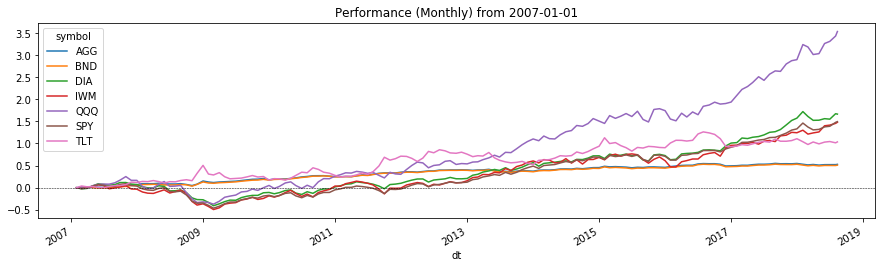

dt symbol     open    high      low   close  \
dt         symbol                                                       
2018-08-10 QQQ    2018-08-10    QQQ  176.870  182.63  175.790  180.52   
           DIA    2018-08-10    DIA  253.900  256.76  251.030  253.30   
           SPY    2018-08-10    SPY  281.560  286.01  279.160  283.16   
           IWM    2018-08-10    IWM  165.700  168.71  164.495  167.53   
           TLT    2018-08-10    TLT  118.285  121.05  118.070  120.66   
           AGG    2018-08-10    AGG  105.550  106.36  105.512  106.23   
           BND    2018-08-10    BND   78.750   79.25   78.650   79.18   

                      volume     adj  pct_close  performance  
dt         symbol                                             
2018-08-10 QQQ     243271137  180.52   1.023066     3.532080  
           DIA      22812877  253.30   0.996577     1.664173  
           SPY     408720179  283.16   1.006505     1.493708  
           IWM     135056634  167.53   1.010008     1.479294  
           TLT      54717202  120.66   1.010272     1.035428  
           AGG      25861846  106.23   1.003981     0.527823  
           BND      19788791   79.18   1.004909     0.508747

In [14]:
rolling_prod = lambda x: x.rolling(len(x), min_periods=1).apply(np.prod)  # cumulative return

monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules) \
          .set_index(['dt', 'symbol'], drop=False)
# Get monthly changes in percent around 1 and set first items to 1
monthly['pct_close'] = monthly.groupby(level=1)['close'].pct_change().fillna(0) + 1

fltr = monthly.dt >= '2007-01-01'
test = monthly[fltr].copy().set_index(['dt', 'symbol'], drop=False)  # update index in new dataframe

test.loc[test.index.levels[0][0], 'pct_close'] = 1  # set start position
test['performance'] = test.groupby(level=1)['pct_close'].transform(rolling_prod) - 1
ax = test.performance.unstack(1).plot(title="Performance (Monthly) from 2007-01-01", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()
test.tail(len(test.index.levels[1])).sort_values('performance', ascending=False)

# Rebalance

### Добавим значения индикаторов на всю историю

In [15]:
# Смещаем данные на 1 день вперед, чтобы не заглядывать в будущее
df['sma50'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=50)).shift(1)
df['sma200'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=200)).shift(1)
df['rsi100'] = df.groupby(level=1)['close'].transform(lambda x: talib.RSI(x.values, timeperiod=100)).shift(1)

In [16]:
# расширим правила группировки
agg_rules_indy = agg_rules.copy()
agg_rules_indy['sma50'] = 'first'
agg_rules_indy['sma200'] = 'first'
agg_rules_indy['rsi100'] = 'first'

# группируем по неделям(W)/месяцам(M)/годам(Y)
grouped = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules_indy) \
          .set_index(['dt', 'symbol'], drop=False)
grouped['pct_close'] = grouped.groupby(level=1)['close'].pct_change().fillna(0) + 1
grouped['rebalance_dt'] = grouped.groupby(level=1)['dt'].shift(1) # to exclude future error
grouped.tail(len(grouped.index.levels[1]))

dt symbol     open    high      low   close  \
dt         symbol                                                       
2018-08-10 AGG    2018-08-10    AGG  105.550  106.36  105.512  106.23   
           BND    2018-08-10    BND   78.750   79.25   78.650   79.18   
           DIA    2018-08-10    DIA  253.900  256.76  251.030  253.30   
           IWM    2018-08-10    IWM  165.700  168.71  164.495  167.53   
           QQQ    2018-08-10    QQQ  176.870  182.63  175.790  180.52   
           SPY    2018-08-10    SPY  281.560  286.01  279.160  283.16   
           TLT    2018-08-10    TLT  118.285  121.05  118.070  120.66   

                      volume     adj       sma50      sma200     rsi100  \
dt         symbol                                                         
2018-08-10 AGG      25861846  106.23  120.056992  120.328874  49.528893   
           BND      19788791   79.18  105.651910  106.106318  49.408251   
           DIA      22812877  253.30   78.748619   79.112376  49.162293   
           IWM     135056634  167.53  248.208972  243.986876  54.323526   
           QQQ     243271137  180.52  165.845982  155.683572  54.819701   
           SPY     408720179  283.16  175.054978  163.813377  55.295013   
           TLT      54717202  120.66  275.977058  267.720318  55.118911   

                   pct_close rebalance_dt  
dt         symbol                          
2018-08-10 AGG      1.003981   2018-07-31  
           BND      1.004909   2018-07-31  
           DIA      0.996577   2018-07-31  
           IWM      1.010008   2018-07-31  
           QQQ      1.023066   2018-07-31  
           SPY      1.006505   2018-07-31  
           TLT      1.010272   2018-07-31

### Ребалансируем несколько портфелей

In [17]:
fltr = (grouped.dt >= '2004-01-01') & (grouped.dt < '2020-01-01')
rebalance = grouped[fltr].copy().set_index(['dt', 'symbol'], drop=False)  # update index
rebalance.loc[rebalance.index.levels[0][0], 'pct_close'] = 1  # set start position
rebalance['performance'] = rebalance.groupby(level=1)['pct_close'].transform(rolling_prod) - 1  # reset performance

def rebalance_simple(x):
    # simple rebalance every step
    data = x.unstack(1)
    return (data.pct_close * data['size']).sum() / data['size'].sum()

def rebalance_sma(x):
    # rebalance every step and buy symbols with SMA50 > SMA200
    data = x.unstack(1)
    fltr = data['sma50'] > data['sma200']
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_rsi(x):
    # rebalance every step and buy symbols with RSI100 > 50
    data = x.unstack(1)
    fltr = data['rsi100'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_custom(x, df=None):
    # rebalance every step and buy symbols with custom signals
    data = x.unstack(1)
    for s in data.index:
        if data['dt'][s]:
            fltr_dt = df['dt'] < data['rebalance_dt'][s]
            values = df[fltr_dt].loc[(slice(None), [s]), 'close'].values
            data.loc[s, 'custom'] = 0
            if len(values) > len(values[np.isnan(values)]):                
                # data.loc[s, 'custom'] = talib.SMA(values, timeperiod=50)[-1] - talib.SMA(values, timeperiod=200)[-1]
                data.loc[s, 'custom'] = talib.RSI(values, timeperiod=100)[-1]
    
    fltr = data['custom'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def drawdown(chg, is_max=False):
    # max drawdowns of returns
    total = len(chg.index)
    rolling_max = chg.rolling(total, min_periods=1).max()
    daily_drawdown = chg/rolling_max - 1.0
    if is_max:
        return daily_drawdown.rolling(total, min_periods=1).min()
    return daily_drawdown

In [18]:
# test cell, may skip
p = {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 
     'func': partial(rebalance_custom, df=df), 
     'name': 'Portfolio 80/20 Custom'}
# reset rebalance size
rebalance['size'] = 0.
for s, pct in p['symbols']:
    rebalance.loc[(slice(None), [s]), 'size'] = pct
rebalance.tail(len(rebalance.index.levels[1]))
rebalance_perf = rebalance.stack().unstack([1, 2]).apply(p['func'], axis=1)
p['performance'] = (rebalance_perf.rolling(len(rebalance_perf), min_periods=1).apply(np.prod) - 1)
p['drawdown'] = drawdown(p['performance'] + 1, is_max=True)

### Portfolios

In [19]:
portfolios = [
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_sma, 'name': 'Portfolio 80/20 SMA50x200'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_rsi, 'name': 'Portfolio 80/20 RSI100>50'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': partial(rebalance_custom, df=df), 'name': 'Portfolio 80/20 Custom'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_simple, 'name': 'Portfolio 80/20'},
    {'symbols': [('SPY', 0.4), ('AGG', 0.6)], 'func': rebalance_simple, 'name': 'Portfolio 40/60'},
    {'symbols': [('SPY', 0.2), ('AGG', 0.8)], 'func': rebalance_simple, 'name': 'Portfolio 20/80'},
    {'symbols': [('DIA', 0.2), ('QQQ', 0.3), ('SPY', 0.2), ('IWM', 0.2), ('AGG', 0.1)], 
     'func': rebalance_simple, 'name': 'Portfolio DIA & QQQ & SPY & IWM & AGG'},
]

for p in portfolios:
    # reset rebalance size
    rebalance['size'] = 0.
    for s, pct in p['symbols']:
        rebalance.loc[(slice(None), [s]), 'size'] = pct
    rebalance_perf = rebalance.stack().unstack([1, 2]).apply(p['func'], axis=1)
    p['performance'] = (rebalance_perf.rolling(len(rebalance_perf), min_periods=1).apply(np.prod) - 1)
    p['drawdown'] = drawdown(p['performance'] + 1, is_max=True)
    
print("Total: ", len(portfolios))

Total:  7


# Графики портфелей

Portfolio 80/20 SMA50x200: 202.17% / -14.51%
Portfolio 80/20 RSI100>50: 261.80% / -15.46%
Portfolio 80/20 Custom: 194.01% / -15.39%
Portfolio 80/20: 197.26% / -42.18%
Portfolio 40/60: 128.18% / -21.02%
Portfolio 20/80: 96.63% / -9.91%
Portfolio DIA & QQQ & SPY & IWM & AGG: 280.33% / -45.42%


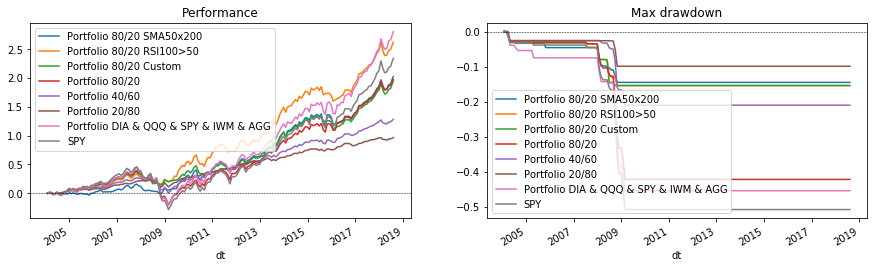

In [20]:
fig = plt.figure(figsize=(15, 4), facecolor='white')

ax_perf = fig.add_subplot(121)
ax_dd = fig.add_subplot(122)
for p in portfolios:
    p['performance'].rename(p['name']).plot(ax=ax_perf, legend=True, title='Performance')
    p['drawdown'].rename(p['name']).plot(ax=ax_dd, legend=True, title='Max drawdown')
    print(f"{p['name']}: {p['performance'][-1]*100:.2f}% / {p['drawdown'][-1]*100:.2f}%")

rebalance.loc[(slice(None), ['SPY']), :].set_index('dt', drop=False).performance. \
    rename('SPY').plot(ax=ax_perf, legend=True)
drawdown(rebalance.loc[(slice(None), ['SPY']), :].set_index('dt', drop=False).performance + 1, 
         is_max=True).rename('SPY').plot(ax=ax_dd, legend=True)

ax_perf.axhline(0, color='k', linestyle='--', lw=0.5)
ax_dd.axhline(0, color='k', linestyle='--', lw=0.5)

plt.show()

# Testing